First, let's install the OpenAI gym and Atari environment:

In [ ]:
!pip install gym gym[atari]

Needed imports

In [1]:
import gym, time
import matplotlib.pyplot as plt
import numpy as np
from skimage import color

In [2]:
from collections import deque
from copy import deepcopy
import random

# BattleZone environment
Actually, there are 12 environments. The main difference is the observation type:
* The "normal" environments: observations are the frames of the game. They are bigger and more complex to analyse, but more intuitive.
* The RAM environments: observations are a 128-byte arrays, representing the RAM of the Atari console. Lighter to use, but we do not know what each byte represents.

The environment is provided in binary so we cannot modify it. Besides, it is hard to replicate the logic behind the spawning of enemies, so we chose to use the OpenAI environments directly. Moreover, the RAM environments are not interpretable, so we go for environments where the observation is the raw image.

List of all environments (we choose the first one):

```'BattleZone-v0', 
'BattleZone-v4',
'BattleZoneDeterministic-v0', 
'BattleZoneDeterministic-v4', 
'BattleZoneNoFrameskip-v0', 
'BattleZoneNoFrameskip-v4',
'BattleZone-ram-v0',
'BattleZone-ram-v4',
'BattleZone-ramDeterministic-v0', 
'BattleZone-ramDeterministic-v4', 
'BattleZone-ramNoFrameskip-v0',
'BattleZone-ramNoFrameskip-v4'```

## Chosen environment: ```BattleZone-v4```

Global variable for rendering

In [11]:
RENDER = False

In [7]:
env = gym.make('BattleZone-v4')
_ = env.reset()

In [8]:
for _ in range(2000):
    obs, rew, done, info = env.step(env.action_space.sample()) # take a random action
    if RENDER:
        env.render()
        time.sleep(0.02)
env.close()

Observation (210x160 RGB image)

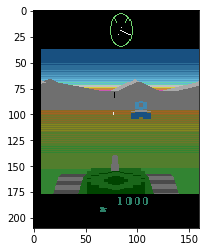

In [9]:
plt.imshow(obs)

In [10]:
obs.shape

(210, 160, 3)

### Preprocessing

We try to get the dimensions of the interesting parts of the observation:
* The radar part (that is in the top middle part of the frame)

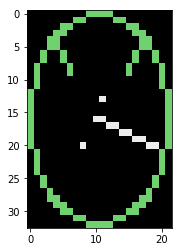

In [12]:
plt.imshow(obs[3:36,74:96])

* The view from the tank's cockpit, restrained to the green field (and a little of the background mountains) which will contain the moving enemies as well as the projectiles' range and most importantly the cursor indicating what is directly in front of our tank

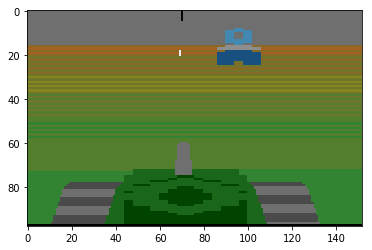

In [13]:
plt.imshow(obs[80:178,8:])

We define our preprocessing functions:

In [14]:
def to_gray(img):
    # Convert images to grayscale with values between 0 and 1
    return color.rgb2gray(img).astype(np.float32)

In [15]:
def downsample(img):
    # Downsampling an image for faster computing
    return img[::2, ::2]

In [16]:
def preprocessing(obs):
    radar = obs[3:36,74:96]
    scene = obs[80:178,8:]
    radar = to_gray(radar)
    scene = downsample(to_gray(scene))
    return radar, scene

In [17]:
radar, scene = preprocessing(obs)

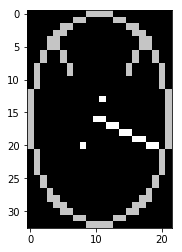

In [18]:
plt.imshow(radar, cmap="gray")

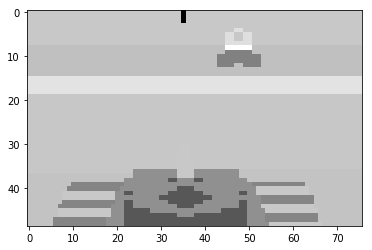

In [19]:
plt.imshow(scene, cmap="gray")

In [20]:
print(radar.shape, scene.shape)

(33, 22) (49, 76)


# The agent

Imports:

In [21]:
from keras.layers import Input, Flatten, Dense, Concatenate, Multiply, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import RMSprop

from keras import backend as K
from keras.utils import plot_model

Using TensorFlow backend.


We will be giving the model a number of frames at a time (the time of the last projectile sent can be a determining factor, so the agent may need it).

In [125]:
n_frames = 2 #Number of input frames per input
n_actions = 18 #Dimension of action space
batch_size = 128 #Number of entries (states+actions) to feed the NN
memory_size = 10000 # Memory size for experience replay
n_repetition = 3 # Number of frames for which same action is repeated

Hyperparameters for training

In [42]:
gamma = 0.99
epsilon = 1e-7
learning_rate = 0.00025

We will use a Huber loss function for our model to prevent heavy penalization of high errors (linear instead of quadratic). We will implement the function so it can be used within a Keras neural network.

In [25]:
def huber_loss(a, b):
    e = a - b
    quad = e**2 / 2
    lin = abs(e) - 1/2
    use_lin = (abs(e) > 1.0)
    use_lin = K.cast(use_lin, 'float32')
    return use_lin * lin + ( 1 - use_lin) * quad

Let us define our model:

In [138]:
def model():
    
    # Shape of entries
    scene_shape = (n_frames, 49, 76,)
    radar_shape = (n_frames, 33 * 22,) # Since we will be using a fully connected network here,
                                    # we will provide a flattened version of the radar frame
    
    # Input layers
    scene_inp = Input(scene_shape, name='scenes')
    radar_inp = Input(radar_shape, name='radars')
    actions_inp = Input((n_actions,), name='actions')
    
    # Hidden layers for the scene
    conv1 = Conv2D(filters=8,
                   kernel_size=(8, 8),
                   strides=(4, 4),
                   activation='relu',
                   data_format="channels_first")(scene_inp)
    
    maxpool1 = MaxPooling2D(pool_size=(4, 4),
                            strides=(4, 4))(conv1)
   
    scene_output = Flatten('channels_first')(maxpool1)
    
    # Hidden layers for the radar
    
    radar_hidden = Dense(512, activation="relu")(radar_inp)
    radar_hidden_flattened = Flatten()(radar_hidden)
    radar_output = Dense(128, activation="relu")(radar_hidden_flattened)
        
    # Last hidden layer
    hidden_last = Concatenate(axis=1)([scene_output, radar_output])
    
    # Output
    output = Dense(n_actions, activation='softmax')(hidden_last)

    # Multiply by the actions (mask for training)
    filtered_output = Multiply()([output, actions_inp])
    
    # Create the model
    model = Model(input=[scene_inp, radar_inp, actions_inp], 
                  output=filtered_output,
                 )
    
    # Optimizer choice and tuning
    rms = RMSprop(lr = learning_rate)
    
    # Compiling
    model.compile(optimizer=rms, loss=huber_loss)
    
    return model
    

Defining the model and visualising its graph

In [137]:
model= model()
plot_model(model,
           to_file='model.png',
           show_shapes=True)

TypeError: __call__() missing 1 required positional argument: 'inputs'

Functions for preprocessing the observation and choosing an action:

In [45]:
def stack_frames(stacked_radars, stacked_scenes, observation):
    radar, scene = preprocessing(observation)
    if (len(stacked_radars) < n_frames):
        for _ in range(n_frames):
            stacked_radars.append(radar)
            stacked_scenes.append(scene)
    else:
        stacked_radars.append(radar)
        stacked_scenes.append(scene)
    return stacked_radars, stacked_scenes

In [46]:
def choose_action(model, stacked_radars, stacked_scenes, batch_size=1):
# Choose the best action according to the model's prediction

    # Reshaping for the model to use
    radars = list(stacked_radars)
    radars = np.reshape(radars, (batch_size, n_frames, 22 * 33))
    
    scenes = list(stacked_scenes)
    scenes = np.reshape(scenes, (batch_size, n_frames, 49, 76))
    
    
    # Predicting the output for a vector of ones
    prediction = model.predict([scenes, radars, np.ones((1,n_actions))])
    
    # Returning the prediction with the max Q-value
    return np.argmax(prediction[0][-1])

Playing a game with the current model

In [70]:
def run_game(n_games, model):
    
    rew_max = 0
    
    for _ in range(n_games):
        
        env.reset()
        
        rew_total = 0
        action = 0
        
        done = False
        is_terminal = np.zeros((1, 18))
        
        stacked_radars = deque([], maxlen=n_frames)
        stacked_scenes = deque([], maxlen=n_frames)
        
        previous_radars = list()
        previous_scenes = list()
        
        while not done :
            
            if RENDER:
                env.render()
                time.sleep(0.01)
            
            for _ in range(n_repetition):
                observation, rew, done, info = env.step(action)
            
            rew += 0.1 # We reward our agent for surviving
            rew_total += rew
            
            stacked_radars, stacked_scenes = stack_frames(stacked_radars, stacked_scenes, observation)
            
            action = choose_action(model, stacked_radars, stacked_scenes)
            
            if done:
                is_terminal[0,action] = True
                        
            
        rew_max = max(rew_max, rew_total)
        env.close()
    
    return rew_max

In [71]:
run_game(1, model)

53.800000000000495

# Training the agent

## Memory for experience replay
We will be using a buffer (a ring buffer specifically) in order to put a limit to the memory usage (and prevent any saturation or malfunctioning of our agent).

In [130]:
class RingBuf:
    
    def __init__(self, size):
        # We allocate one extra element, so that self.start == self.end always means the buffer is empty
        self.data = [None] * (size + 1) # Size will indicate the size of memory we want to allocate
        self.start = 0
        self.end = 0
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start means the buffer has one too many elements
        # We then remove the first element by incrementing start
        if (self.end == self.start):
            self.start = (self.start + 1) % len(self.data)
        
    def __getitem__(self, index):
        return self.data[(self.start + index) % len(self.data)]
    
    def __len__(self):
        if (self.end < self.start):
            return (self.end + len(self.data) - self.start)
        else:
            return (self.end - self.start)
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
    
    def get_sample(self, size):
        l = list()
        for _ in range(size):
            if self.end < self.start:
                i = random.randint(0, len(self))
            l.append(self.data[i])
        return l

In [48]:
memory = RingBuf(memory_size)

Now that our model and memory are defined, we will implement a function that will run a fitting iteration: We will be using a Deep Q-learning approach, improving our network everytime the agent makes an action. When fitting, we fit a new model using the Q-values from a target model for more stability.

In [127]:
def fit_iteration(model, target_model, start_scenes, start_radars, actions, rewards, next_scenes, next_radars, is_terminal):
    
    # First, we predict the Q values of the next states. We pass ones as the "mask".
    next_Q_values = target_model.predict([next_scenes, next_radars, np.ones((batch_size, n_actions))])
    
    # The Q value a terminal state is 0 by definition
    next_Q_values[is_terminal] = 0
    
    # We apply the formula of the Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=0)
    
    # Fit the model.
    model.fit([start_scenes, start_radars, actions], actions * Q_values[:, None], nb_epoch=2, batch_size=len(start_scenes), verbose=0)
    
    return model

A function that returns the probability for epsilon-greedy exploration:

In [107]:
def epsilon_from_iter(i):
    if (i > epsilon):
        return 0.1
    else:
        return (1 - epsilon * 0.9 * i)

A utility function to save the model to a file

In [108]:
def copy_model(model):
    model.save('tmp_model')
    return load_model('tmp_model', custom_objects={'huber_loss': huber_loss})

In [131]:
def run_train(n_games, model, memory):
    
    i = 0
    
    for _ in range(n_games):
    
        j = 0
        env.reset()

        action = 0
        done = False
        is_terminal = np.zeros((1, n_actions))

        stacked_radars = deque([], maxlen=n_frames)
        stacked_scenes = deque([], maxlen=n_frames)
        previous_radars = list()
        previous_scenes = list()

        while not done:

            if RENDER:
                env.render()

            for _ in range(n_repetition):
                observation, rew, done, info = env.step(action)

            rew += 0.1 

            previous_radars = deepcopy(stacked_radars)
            previous_scenes = deepcopy(stacked_scenes)

            stacked_radars, stacked_scenes = stack_frames(stacked_radars, stacked_scenes, observation)

            if np.random.uniform() > epsilon_from_iter(i) and len(stacked_radars) == n_frames:
                action = choose_action(model, stacked_radars, stacked_scenes)
            else:
                action = env.action_space.sample()


            # Preparing data for the memory 
            if done:

                is_terminal[0, action] = 1

            if (j > 0):

                start_radars = np.reshape(list(previous_radars),
                                          (n_frames, previous_radars[0].shape[0]*previous_radars[0].shape[1]))
                next_radars = np.reshape(list(stacked_radars),
                                         (n_frames, stacked_radars[0].shape[0]*stacked_radars[0].shape[1]))

                start_scenes = np.reshape(list(previous_scenes),
                                          (n_frames,
                                           previous_scenes[0].shape[0],
                                           previous_scenes[0].shape[1]))
                next_scenes = np.reshape(list(stacked_scenes),
                                         (n_frames,
                                          stacked_scenes[0].shape[0],
                                          stacked_scenes[0].shape[1]))

                actions = np.zeros((1,n_actions))
                actions[0,action] = 1

                is_terminal = np.zeros((1, n_actions), dtype=np.int16)
                if done:
                    is_terminal[0, action] = 1

                memory.append([start_radars,
                               start_scenes,
                               actions,
                               rew,
                               next_radars,
                               next_scenes,
                               is_terminal])


            # Stabilizing by copying the model every 10000 frames
            if ((i % 10000) == 0 or (i < 5000 and i % 100 == 0)):
                target_model = copy_model(model)

            # Fitting the model every 256 frames
            if (i > memory_size):

                sample = memory.get_sample(batch_size)

                start_radars, start_scenes, actionss, rews, next_radars, next_scenes, is_terminals = [], [], [], [], [], [], []

                for s in sample:

                    start_radars.append(s[0])
                    start_scenes.append(s[1])
                    actionss.append(s[2])
                    rews.append(s[3])
                    next_radars.append(s[4])
                    next_scenes.append(s[5])
                    is_terminals.append(s[6])

                start_scenes = np.reshape(start_scenes, (batch_size, n_frames, 49, 76))
                start_radars = np.reshape(start_radars, (batch_size, n_frames, 22 * 33))
                actionss = np.reshape(actionss, (batch_size, n_actions))
                rews = np.reshape(rews, (batch_size, 1))
                next_scenes = np.reshape(next_scenes, (batch_size, n_frames, 49, 76))
                next_radars = np.reshape(next_radars, (batch_size, n_frames, 22 * 33))
                is_terminals = np.reshape(is_terminals, (batch_size, n_actions))

                print(is_terminals[0])

                model = fit_iteration(model,
                                      target_model, 
                                      start_scenes,
                                      start_radars,
                                      actionss,
                                      rews,
                                      next_scenes,
                                      next_radars,
                                      is_terminals)


            i += 1
            j += 1
            
    return model

In [139]:
model_to_train = model()

memory = RingBuf(memory_size)

model = run_train(5, model_to_train, memory)

/home/elyes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mu...)`
